# AQPC Priority EV Automation - Integration Test Notebook

This notebook demonstrates the complete automated workflow for:
1. Generate sessions using ACNScenarioGenerator
2. Automatic priority selection using PrioritySelector rules
3. Create optimizer with priority_sessions parameter
4. Run simulation
5. Analyze results

In [1]:
%load_ext autoreload
%autoreload 2

## 1. Imports

In [2]:
# Standard library imports
import sys
import copy
from datetime import datetime
from typing import Dict, List, Set, Tuple, Optional

# Third-party imports
import numpy as np
import pandas as pd
import pytz
import matplotlib.pyplot as plt

# ACN-Portal imports
from acnportal import acnsim
from acnportal.acnsim import Simulator
from acnportal.acnsim.network import sites
from acnportal.contrib.acnsim import StochasticNetwork
from acnportal.acnsim.models.evse import get_evse_by_type
from acnportal import algorithms

# Modified AdaCharge imports
from modified_adacharge.modified_interface import Interface, SessionInfo, InfrastructureInfo
from modified_adacharge.modified_adaptive_charging_optimization_with_priority import (
    AdaptiveChargingOptimizationWithPriority,
    ObjectiveComponent,
    InfeasibilityException
)
from modified_adacharge.acn_scenario_generator_with_priority import (
    ACNScenarioGenerator,
    SCENARIOS,
    PriorityConfig,
    generate_scenario_with_priorities,
    list_scenarios
)
from modified_adacharge.modified_adaptive_charging_optimization import (
    tou_energy_cost_with_pv,
    non_completion_penalty,
    quick_charge
)

from utility_functions.signals.tariffs.tou_tariff import TimeOfUseTariff
from modified_adacharge import modified_adacharge
from modified_simulator import modified_simulator

print("All imports successful!")
# print(f"Available scenarios: {list_scenarios()}")

All imports successful!


## 2. Configuration Parameters

In [3]:
# Simulation parameters (matching your existing setup)
PERIOD = 5  # minutes
VOLTAGE = 415  # V
MAX_POWER_KW = 21  # kW (maximum battery charging power)
NUM_EVSES = 15
NUM_SESSIONS = 45

# Priority configuration
PRIORITY_CONFIG = PriorityConfig(
    max_priority_pct=0.27,  # Maximum 27% priority vehicles
    min_energy_kwh=10,
    max_energy_kwh=30,
    min_duration_hours=2.0,
    high_energy_threshold=25,
    high_energy_min_duration=3.0
)

# Timezone
TIMEZONE = pytz.timezone('Australia/Melbourne')

print(f"Configuration:")
print(f"  - Period: {PERIOD} min")
print(f"  - Voltage: {VOLTAGE} V")
print(f"  - Max Power: {MAX_POWER_KW} kW")
print(f"  - EVSEs: {NUM_EVSES}")
print(f"  - Sessions: {NUM_SESSIONS}")
print(f"  - Max priority %: {PRIORITY_CONFIG.max_priority_pct*100:.0f}%")

Configuration:
  - Period: 5 min
  - Voltage: 415 V
  - Max Power: 21 kW
  - EVSEs: 15
  - Sessions: 45
  - Max priority %: 27%


## 3. Generate Scenario with Automated Priority Selection

In [7]:
# Generate scenario S1_baseline
# Available scenarios: S1_baseline, S2_low_priority, S3_high_priority, 
#                      S4_morning_rush, S5_cloudy_day, S6_peak_stress
scenario_name = 'S1_baseline'

events, priority_ids, session_params = generate_scenario_with_priorities(
    scenario_key=scenario_name,
    n_sessions=NUM_SESSIONS,
    period=PERIOD,
    voltage=415,  # Match your network voltage
    max_battery_power=MAX_POWER_KW,
    # seed=42,
    priority_config=PRIORITY_CONFIG
)

print(f"\nScenario {scenario_name} Generated:")
print(f"  - Total sessions: {len(session_params)}")
print(f"  - Priority EVs: {len(priority_ids)} ({len(priority_ids)/len(session_params)*100:.1f}%)")
print(f"  - Priority session IDs: {sorted(list(priority_ids))}")


Scenario S1_baseline Generated:
  - Total sessions: 45
  - Priority EVs: 12 (26.7%)
  - Priority session IDs: ['session_0', 'session_23', 'session_24', 'session_25', 'session_30', 'session_31', 'session_32', 'session_35', 'session_39', 'session_4', 'session_42', 'session_43']


In [8]:
# Checking session details
from copy import deepcopy

session_copy = deepcopy(events)
# print(type(session_copy))
session_list = list(session_copy.queue)
for session in session_list:
    print(session[0], session[1].ev._session_id, session[1].ev.arrival, \
          session[1].ev.departure, session[1].ev.requested_energy, session[1].event_type)

73 session_5 73 167 6.51 Plugin
77 session_40 77 159 26.98 Plugin
80 session_2 80 112 9.11 Plugin
78 session_16 78 104 18.18 Plugin
78 session_9 78 122 38.26 Plugin
88 session_1 88 147 5.4 Plugin
91 session_28 91 116 17.27 Plugin
82 session_34 82 116 9.48 Plugin
91 session_35 91 162 11.37 Plugin
101 session_39 101 151 22.62 Plugin
125 session_43 125 184 26.64 Plugin
88 session_24 88 160 23.21 Plugin
146 session_25 146 232 24.32 Plugin
116 session_13 116 199 28.97 Plugin
128 session_29 128 183 36.65 Plugin
142 session_32 142 185 21.07 Plugin
137 session_8 137 206 25.45 Plugin
183 session_0 183 248 19.85 Plugin
97 session_38 97 127 9.22 Plugin
113 session_4 113 199 12.83 Plugin
188 session_42 188 265 11.46 Plugin
136 session_22 136 170 38.39 Plugin
137 session_10 137 206 14.71 Plugin
138 session_11 138 188 25.43 Plugin
104 session_23 104 177 26.63 Plugin
212 session_12 212 287 29.44 Plugin
198 session_26 198 251 9.69 Plugin
180 session_27 180 249 29.64 Plugin
147 session_6 147 243 7.58 P

## 4. Create Charging Network

In [9]:
def ev_fleet_level_2_network(transformer_cap=130):
    """ Configurable charging network for level-2 EVSEs connected line to line
        at 415 V.

    Args:
        transformer_cap (float): Capacity of the transformer feeding the network
          [kW]
        evse_per_phase (int): Number of EVSEs on each phase. Total number of
          EVSEs will be 3 * evse_per_phase.

    Returns:
        ChargingNetwork: Configured ChargingNetwork.
    """
    network = StochasticNetwork(early_departure=True)
    # network = ChargingNetwork()
    voltage = 415
    evse_type = 'AeroVironment'
    # evse_type = 'ClipperCreek'

    # Define the sets of EVSEs in the Caltech ACN.
    AB_ids = ['AB-{0}'.format(i) for i in range(5)]
    BC_ids = ['BC-{0}'.format(i) for i in range(5)]
    CA_ids = ['CA-{0}'.format(i) for i in range(5)]

    # print(AB_ids)

    # Add Caltech EVSEs
    for evse_id in AB_ids:
        network.register_evse(get_evse_by_type(evse_id, evse_type), voltage, 30)
    for evse_id in BC_ids:
        network.register_evse(get_evse_by_type(evse_id, evse_type), voltage, -90)
    for evse_id in CA_ids:
        network.register_evse(get_evse_by_type(evse_id, evse_type), voltage, 150)

    # Add Caltech Constraint Set
    AB = acnsim.Current(AB_ids)
    BC = acnsim.Current(BC_ids)
    CA = acnsim.Current(CA_ids)

    # Define intermediate currents
    I3a = AB - CA
    I3b = BC - AB
    I3c = CA - BC
    I2a = (1 / 4) * (I3a - I3c)
    I2b = (1 / 4) * (I3b - I3a)
    I2c = (1 / 4) * (I3c - I3b)

    # Build constraint set
    primary_side_constr = transformer_cap * 1000 / 3 / 415
    print(primary_side_constr)
    secondary_side_constr = transformer_cap * 1000 / 3 / 230
    print(secondary_side_constr)
    network.add_constraint(I3a, secondary_side_constr, name='Secondary A')
    network.add_constraint(I3b, secondary_side_constr, name='Secondary B')
    network.add_constraint(I3c, secondary_side_constr, name='Secondary C')
    network.add_constraint(I2a, primary_side_constr, name='Primary A')
    network.add_constraint(I2b, primary_side_constr, name='Primary B')
    network.add_constraint(I2c, primary_side_constr, name='Primary C')

    return network

## 5. Setup Simulation Parameters

In [10]:
# Simulation start time
start_time = TIMEZONE.localize(datetime(2026, 1, 7, 0, 0, 0))

# TOU tariff structure (example - adjust based on your utility)
# Peak: 7-9 AM and 5-9 PM, Off-peak: other times
def get_tou_tariff(period_minutes: int = 5) -> np.ndarray:
    """
    Generate TOU tariff array for 24 hours.
    
    Returns:
        Array of prices per period ($/kWh)
    """
    periods_per_hour = 60 // period_minutes
    total_periods = 24 * periods_per_hour
    
    tariff = np.zeros(total_periods)
    
    for period in range(total_periods):
        hour = period // periods_per_hour
        
        # Peak hours: 7-9 AM and 5-9 PM
        if (7 <= hour < 9) or (17 <= hour < 21):
            tariff[period] = 0.35  # Peak rate $/kWh
        # Shoulder: 9 AM - 5 PM
        elif 9 <= hour < 17:
            tariff[period] = 0.25  # Shoulder rate
        # Off-peak: other times
        else:
            tariff[period] = 0.12  # Off-peak rate
    
    return tariff

tariff = get_tou_tariff(PERIOD)
print(f"TOU tariff generated: {len(tariff)} periods")
print(f"  - Peak rate: ${tariff.max():.2f}/kWh")
print(f"  - Off-peak rate: ${tariff.min():.2f}/kWh")

TOU tariff generated: 288 periods
  - Peak rate: $0.35/kWh
  - Off-peak rate: $0.12/kWh


## 6. Run Simulation with Different Algorithms

In [11]:
def run_simulation(network, events, scheduler, start_time, period=5):
    """
    Run ACN-Sim simulation with given scheduler.
    
    Args:
        network: ChargingNetwork object
        events: EventQueue with PluginEvents
        scheduler: Scheduling algorithm
        start_time: Simulation start datetime
        period: Time period in minutes
        
    Returns:
        Simulator object with results
    """
    # Create fresh copy of network
    sim_network = copy.deepcopy(network)
    signals = {'tariff': TimeOfUseTariff('sce_tou_ev_4_march_2019')}
    
    # Create simulator
    sim = modified_simulator.Simulator(
        network=sim_network,
        scheduler=scheduler,
        events=events,
        start=start_time,
        period=period,
        signals=signals,
        verbose=True
    )
    
    # Run simulation
    sim.run()
    
    return sim

print("Simulation function defined.")

Simulation function defined.


In [12]:
# Run with AQPC (Adaptive Queuing Priority Charging)
print("Running AQPC simulation...")
cn = ev_fleet_level_2_network(transformer_cap=200)

try:
    # Create AQPC scheduler with priority sessions
    aqpc_scheduler = AdaptiveChargingOptimizationWithPriority(
        objective=[ObjectiveComponent(tou_energy_cost_with_pv, 1.0), ObjectiveComponent(non_completion_penalty), ObjectiveComponent(quick_charge, 1e-6)],
        solver='MOSEK',
        priority_sessions=priority_ids,
        enforce_energy_equality=True
    )
    
    # Run simulation
    aqpc_sim = run_simulation(
        network=cn,
        events=events,
        scheduler=aqpc_scheduler,
        start_time=start_time,
        period=PERIOD
    )
    print("  AQPC simulation completed successfully!")
    
except InfeasibilityException as e:
    print(f"  AQPC encountered infeasibility: {e}")
    aqpc_sim = None
except Exception as e:
    print(f"  AQPC error: {e}")
    aqpc_sim = None

Running AQPC simulation...
160.6425702811245
289.8550724637681
  AQPC error: __init__() missing 1 required positional argument: 'interface'


In [13]:
# Run with AQPC (Adaptive Queuing Priority Charging)
print("Running AQPC simulation...")
cn = ev_fleet_level_2_network(transformer_cap=200)

try:
    # Import the priority scheduler wrapper
    from modified_adacharge.priority_scheduler import AdaptiveSchedulingAlgorithmWithPriority

    # Create AQPC scheduler with priority sessions
    aqpc_scheduler = AdaptiveSchedulingAlgorithmWithPriority(
        objective=[ObjectiveComponent(tou_energy_cost_with_pv), ObjectiveComponent(non_completion_penalty), ObjectiveComponent(quick_charge, 1e-6)],
        solver='MOSEK',
        priority_sessions=priority_ids,
        # enforce_energy_equality=True
    )

    # Run simulation
    aqpc_sim = run_simulation(
        network=cn,
        events=events,
        scheduler=aqpc_scheduler,
        start_time=start_time,
        period=PERIOD
    )
    print("  AQPC simulation completed successfully!")

except InfeasibilityException as e:
    print(f"  AQPC encountered infeasibility: {e}")
    aqpc_sim = None
except Exception as e:
    print(f"  AQPC error: {e}")
    aqpc_sim = None


Running AQPC simulation...
160.6425702811245
289.8550724637681
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Unplug Event...
Plugin Event...
Unplug Event...
Plugin Event...
Unplug Event...
Unplug Event...
Plugin Event...
Unplug Event...
Plugin Event...
Unplug Event...
Unplug Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Plugin Event...
Unplug Event...
Plugin Event...
Unplug Event...
Unplug Event...
Unplug Event...
Plugin Event...
Unplug Event...
Unplug Event...
Unplug Event...
Unplug Event...
Unplug Event...
Plugin Event...
Plugin Event...
Plugin Event...
Unplug Event...
Plugin Event...
Unplug Event...
Unplug Event...
Unplug Event...
Plugin Event...
Plugin Event...
Unplug Event...
Plugin Event...
Plugin Ev

In [14]:
# Run with Round Robin (RR) baseline
print("Running Round Robin simulation...")

try:
    rr_scheduler = algorithms.RoundRobin(algorithms.first_come_first_served, continuous_inc=1)
    rr_sim = run_simulation(
        network=cn,
        events=events,
        scheduler=rr_scheduler,
        start_time=start_time,
        period=PERIOD
    )
    print("  Round Robin simulation completed successfully!")
except Exception as e:
    print(f"  Round Robin error: {e}")
    rr_sim = None

Running Round Robin simulation...
  Round Robin simulation completed successfully!


In [15]:
# Run with Least Laxity First (LLF) baseline
print("Running LLF simulation...")

try:
    llf_scheduler = algorithms.SortedSchedulingAlgo(algorithms.least_laxity_first)
    llf_sim = run_simulation(
        network=cn,
        events=events,
        scheduler=llf_scheduler,
        start_time=start_time,
        period=PERIOD
    )
    print("  LLF simulation completed successfully!")
except Exception as e:
    print(f"  LLF error: {e}")
    llf_sim = None

Running LLF simulation...
  LLF simulation completed successfully!


## 7. Analyze Results

In [17]:
from acnportal.acnsim import analysis

def calculate_metrics(sim, priority_ids: set) -> dict:
    """
    Calculate performance metrics from simulation results.
    
    Args:
        sim: Simulator object
        priority_ids: Set of priority session IDs
        
    Returns:
        Dictionary of metrics
    """
    if sim is None:
        return None
    
    # Overall energy delivery
    total_energy_delivered = analysis.total_energy_delivered(sim)
    total_energy_requested = analysis.total_energy_requested(sim)
    overall_fulfillment = (total_energy_delivered / total_energy_requested * 100 
                          if total_energy_requested > 0 else 0)
    
    # Per-session analysis
    priority_delivered = 0
    priority_requested = 0
    non_priority_delivered = 0
    non_priority_requested = 0
    
    for ev in sim.ev_history.values():
        delivered = ev.energy_delivered
        requested = ev.requested_energy
        session_id = ev._session_id  # Get session_id from the EV object
        
        if session_id in priority_ids:
            priority_delivered += delivered
            priority_requested += requested
        else:
            non_priority_delivered += delivered
            non_priority_requested += requested
    
    priority_fulfillment = (priority_delivered / priority_requested * 100 
                           if priority_requested > 0 else 0)
    non_priority_fulfillment = (non_priority_delivered / non_priority_requested * 100
                               if non_priority_requested > 0 else 0)
    
    # Peak demand
    peak = sim.peak
    
    return {
        'overall_fulfillment': overall_fulfillment,
        'priority_fulfillment': priority_fulfillment,
        'non_priority_fulfillment': non_priority_fulfillment,
        'total_energy_delivered': total_energy_delivered,
        'peak_demand_A': peak
    }

# Calculate metrics for all algorithms
results = {
    'AQPC': aqpc_sim,
    'Round Robin': rr_sim,
    'LLF': llf_sim
}

metrics = {}
for name, sim in results.items():
    if sim is not None:
        metrics[name] = calculate_metrics(sim, priority_ids)

# Display results table
if metrics:
    metrics_df = pd.DataFrame(metrics).T
    print("\n" + "="*70)
    print("SIMULATION RESULTS COMPARISON")
    print("="*70)
    print(metrics_df.round(2).to_string())
else:
    print("No simulation results available.")


SIMULATION RESULTS COMPARISON
             overall_fulfillment  priority_fulfillment  non_priority_fulfillment  total_energy_delivered  peak_demand_A
AQPC                      100.64                 103.4                      99.8                  984.86          224.0
Round Robin                 0.00                   0.0                       0.0                    0.00            0.0
LLF                         0.00                   0.0                       0.0                    0.00            0.0


## 8. Visualization

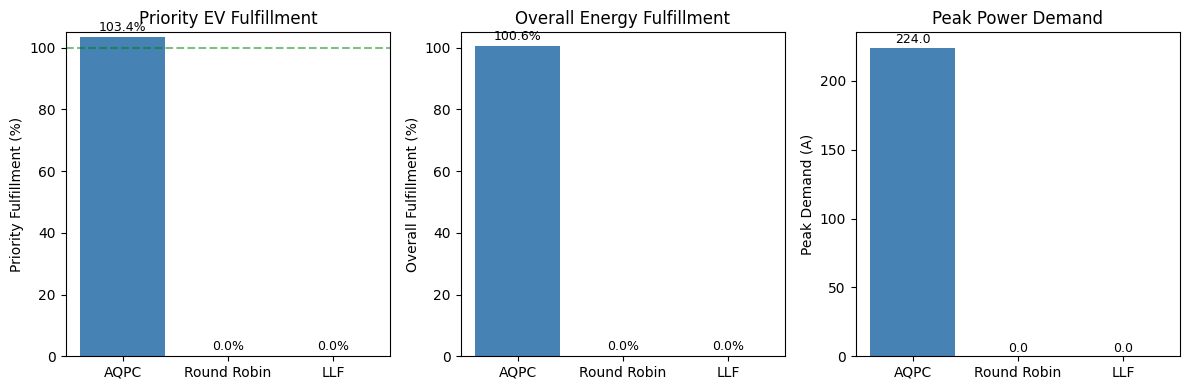


Figure saved as 'integration_test_results.png'


In [20]:
# Create comparison visualization
if metrics:
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    
    alg_names = list(metrics.keys())
    colors = ['steelblue', 'coral', 'seagreen']
    
    # 1. Priority Fulfillment
    ax = axes[0]
    values = [metrics[alg]['priority_fulfillment'] for alg in alg_names]
    bars = ax.bar(alg_names, values, color=colors[:len(alg_names)])
    ax.set_ylabel('Priority Fulfillment (%)')
    ax.set_title('Priority EV Fulfillment')
    ax.set_ylim(0, 105)
    ax.axhline(y=100, color='green', linestyle='--', alpha=0.5, label='Target')
    for bar, val in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                f'{val:.1f}%', ha='center', va='bottom', fontsize=9)
    
    # 2. Overall Fulfillment
    ax = axes[1]
    values = [metrics[alg]['overall_fulfillment'] for alg in alg_names]
    bars = ax.bar(alg_names, values, color=colors[:len(alg_names)])
    ax.set_ylabel('Overall Fulfillment (%)')
    ax.set_title('Overall Energy Fulfillment')
    ax.set_ylim(0, 105)
    for bar, val in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                f'{val:.1f}%', ha='center', va='bottom', fontsize=9)
    
    # 3. Peak Demand
    ax = axes[2]
    values = [metrics[alg]['peak_demand_A'] for alg in alg_names]
    bars = ax.bar(alg_names, values, color=colors[:len(alg_names)])
    ax.set_ylabel('Peak Demand (A)')
    ax.set_title('Peak Power Demand')
    for bar, val in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                f'{val:.1f}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.savefig('integration_test_results.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("\nFigure saved as 'integration_test_results.png'")
else:
    print("No metrics available for visualization.")

## 9. Summary

In [ ]:
print("\n" + "="*70)
print("INTEGRATION TEST SUMMARY")
print("="*70)
print(f"\nScenario: {scenario_name}")
print(f"Total sessions: {len(session_params)}")
print(f"Priority sessions: {len(priority_ids)} ({len(priority_ids)/len(session_params)*100:.1f}%)")

if 'AQPC' in metrics:
    print(f"\nAQPC Performance:")
    print(f"  - Priority fulfillment: {metrics['AQPC']['priority_fulfillment']:.1f}%")
    print(f"  - Overall fulfillment: {metrics['AQPC']['overall_fulfillment']:.1f}%")
    
    if 'Round Robin' in metrics:
        rr_pf = metrics['Round Robin']['priority_fulfillment']
        aqpc_pf = metrics['AQPC']['priority_fulfillment']
        improvement = aqpc_pf - rr_pf
        print(f"\nAQPC vs Round Robin:")
        print(f"  - Priority fulfillment improvement: +{improvement:.1f}%")

print("\n" + "="*70)
print("Integration test completed successfully!")
print("="*70)